# Training on a single site, testing multiple models

In [1]:
import os
import random
import numpy as np
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # disable info log from tensorflow
import tensorflow as tf
from modules.DatasetWrapper import Dataset, Log
from modules.TrainOnOneSite import Trainer
from modules.kerasGenerator import plot_model_info
from IPython.display import Markdown, display
from modules.Plotter import OnePlotter, GeneralPlotter

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import of data

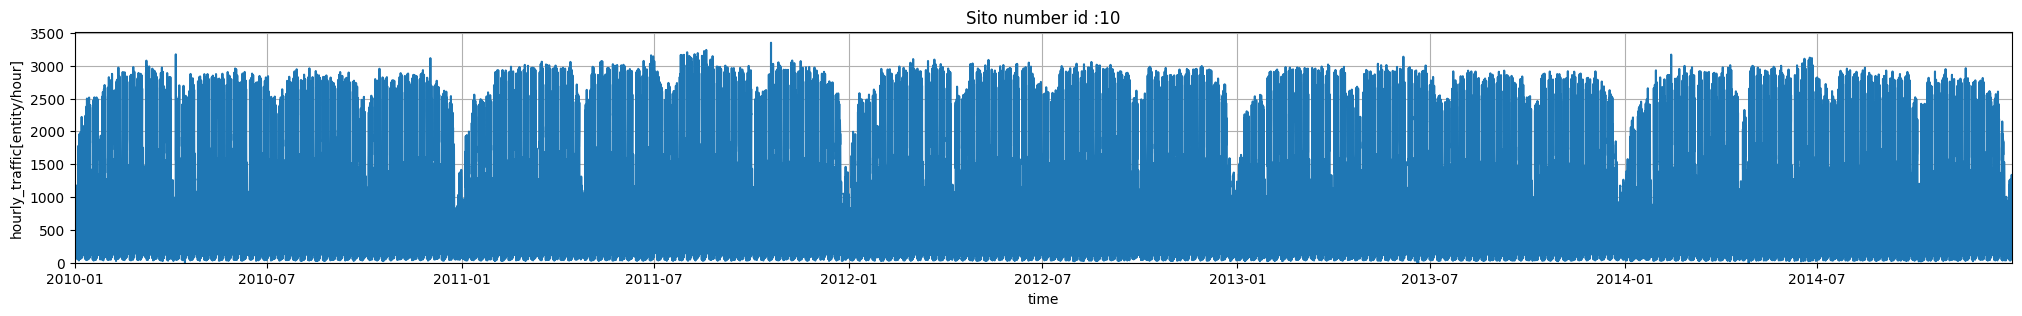

mean       std       min       25%       50%  \
hourly_traffic        0.548256  0.427252  0.000000  0.134444  0.472222   
temperature_2m        0.833086  0.301616  0.117000  0.612000  0.774500   
apparent_temperature  0.721823  0.344139 -0.049737  0.465404  0.656857   
relative_humidity_2m  0.657317  0.197985  0.081371  0.516910  0.679468   
precipitation         0.010049  0.049863  0.000000  0.000000  0.000000   
wind_speed_10m        1.068027  0.514500  0.000000  0.686417  1.012845   
cloud_cover           0.338667  0.311726  0.000000  0.030000  0.288000   

                           75%       max  
hourly_traffic        0.882778  1.861111  
temperature_2m        1.004500  2.019500  
apparent_temperature  0.925835  2.071331  
relative_humidity_2m  0.820077  1.000000  
precipitation         0.000000  1.560000  
wind_speed_10m        1.399428  3.755674  
cloud_cover           0.558000  1.000000

Site type: SIGNALISED_4_WAY_INTERSECTION


In [2]:
site_no = 10
data = Dataset()
Site_data = data.select_site(site_no)

# Signal Band

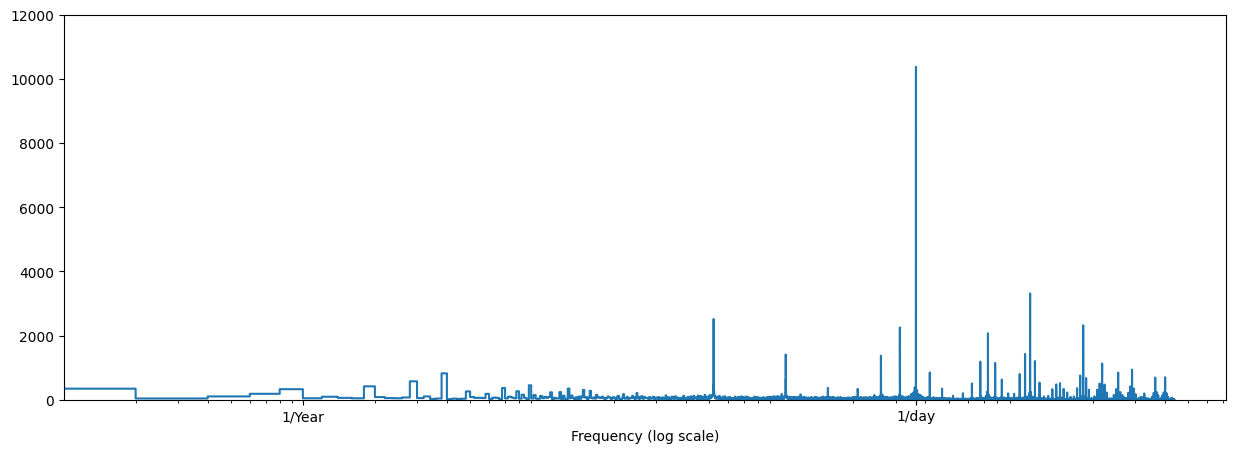

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fft = np.fft.rfft(Site_data["hourly_traffic"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(Site_data["hourly_traffic"])
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.figure(figsize=(15, 5))
plt.step(f_per_year, np.abs(fft))
plt.xscale("log")
plt.ylim(0, 1.2e4)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
plt.xlabel("Frequency (log scale)")
plt.show()
del fft, f_per_dataset, n_samples_h, hours_per_year, years_per_dataset, f_per_year

# Models

### Parametri allenamento

In [5]:
epochs = 12
patience_RLR = 3
patience_ES = 5

sv_model = False
sv_step = False

plot_range = range(0, 24*20)
# --- ---
workspace = "Paper_models"
my_log = Log(workspace)

### Division of Site_data into Train, Validation, Test

In [6]:
X_col = Trainer.NEW_X_FEATURES
window_x = Trainer.NEW_X_WINDOWS

Train, Valid, Test = data.split_and_get_generators(
    training=3, validation=1, test=1, X_col=X_col, input_size=window_x
)
trainer = Trainer(Train, Valid, Test, Workspace=workspace)

## Rete fully connected

### A dense layer: Linear

Model: "Linear"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_52 (Flatten)            │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105 (420.00 B)

 Trainable params: 105 (420.00 B)

 Non-trainable params: 0 (0.00 B)

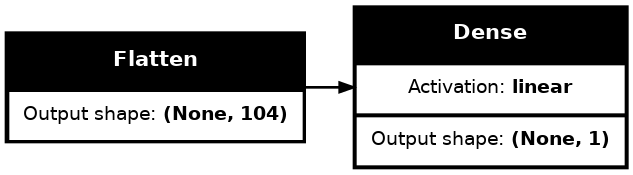

In [73]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(trainer.shape_X)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(trainer.shape_y),
    ]
)
model.name = "Linear"
plot_model_info(model)



Training:



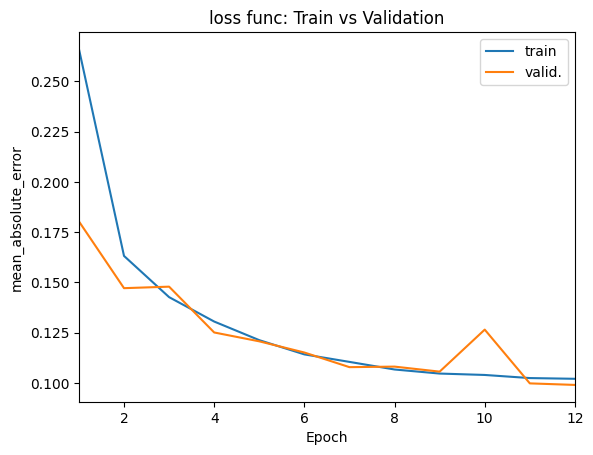

821/821 - 125s - 152ms/step - loss: 0.0226 - mean_absolute_error: 0.1021 - val_loss: 0.0219 - val_mean_absolute_error: 0.0990 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 11.

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 117s 143ms/step
mean_squared_error: 0.0220(0.1483) - mean_absolute_error: 0.0989
DeNorm_mean_squared_error: 71316.6875(267.0518) - DeNorm_mean_absolute_error: 177.9742


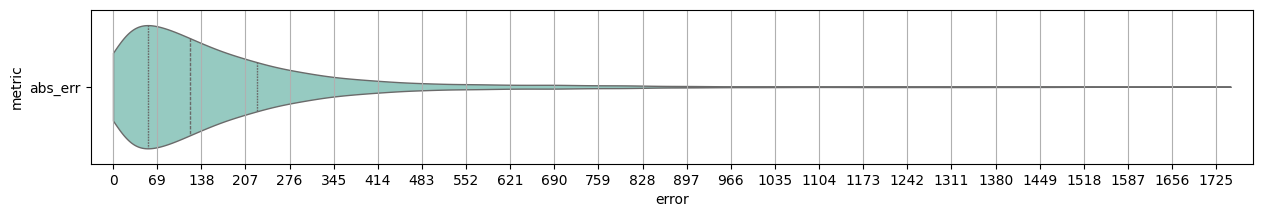

mean        std       min        25%        50%         75%  \
error  177.974229  199.10642  0.003107  55.294309  119.68395  224.802025   

               max  
error  1747.729664


Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step
mean_squared_error: 0.0219(0.1480) - mean_absolute_error: 0.0998
DeNorm_mean_squared_error: 70843.8281(266.1650) - DeNorm_mean_absolute_error: 179.6071


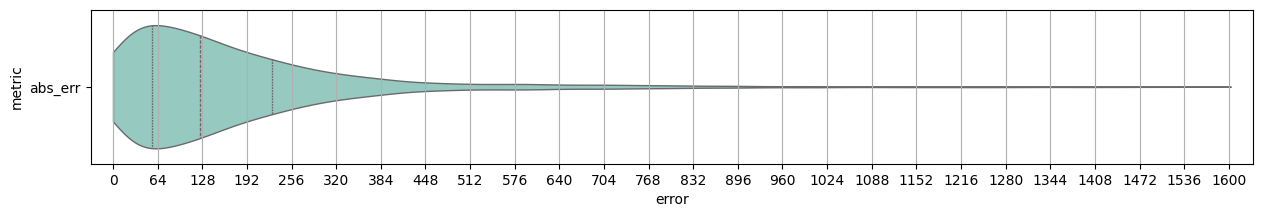

mean         std       min       25%         50%         75%  \
error  179.607078  196.442257  0.009491  56.50232  124.576928  227.779419   

               max  
error  1602.857738


Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step
mean_squared_error: 0.0215(0.1466) - mean_absolute_error: 0.1021
DeNorm_mean_squared_error: 69525.4531(263.6768) - DeNorm_mean_absolute_error: 183.8147


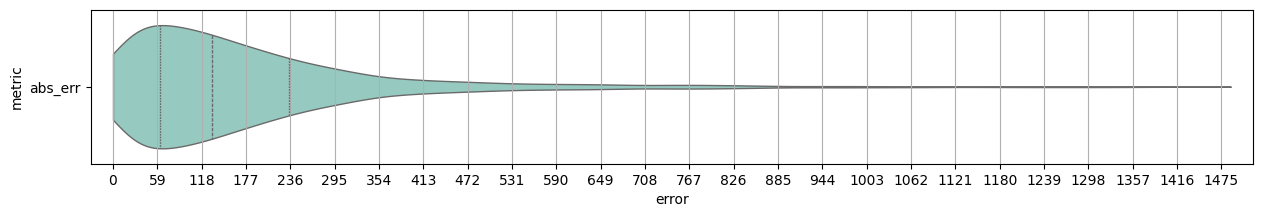

mean         std       min        25%         50%         75%  \
error  183.814757  189.054741  0.030389  62.005126  131.352714  234.709973   

               max  
error  1487.450956

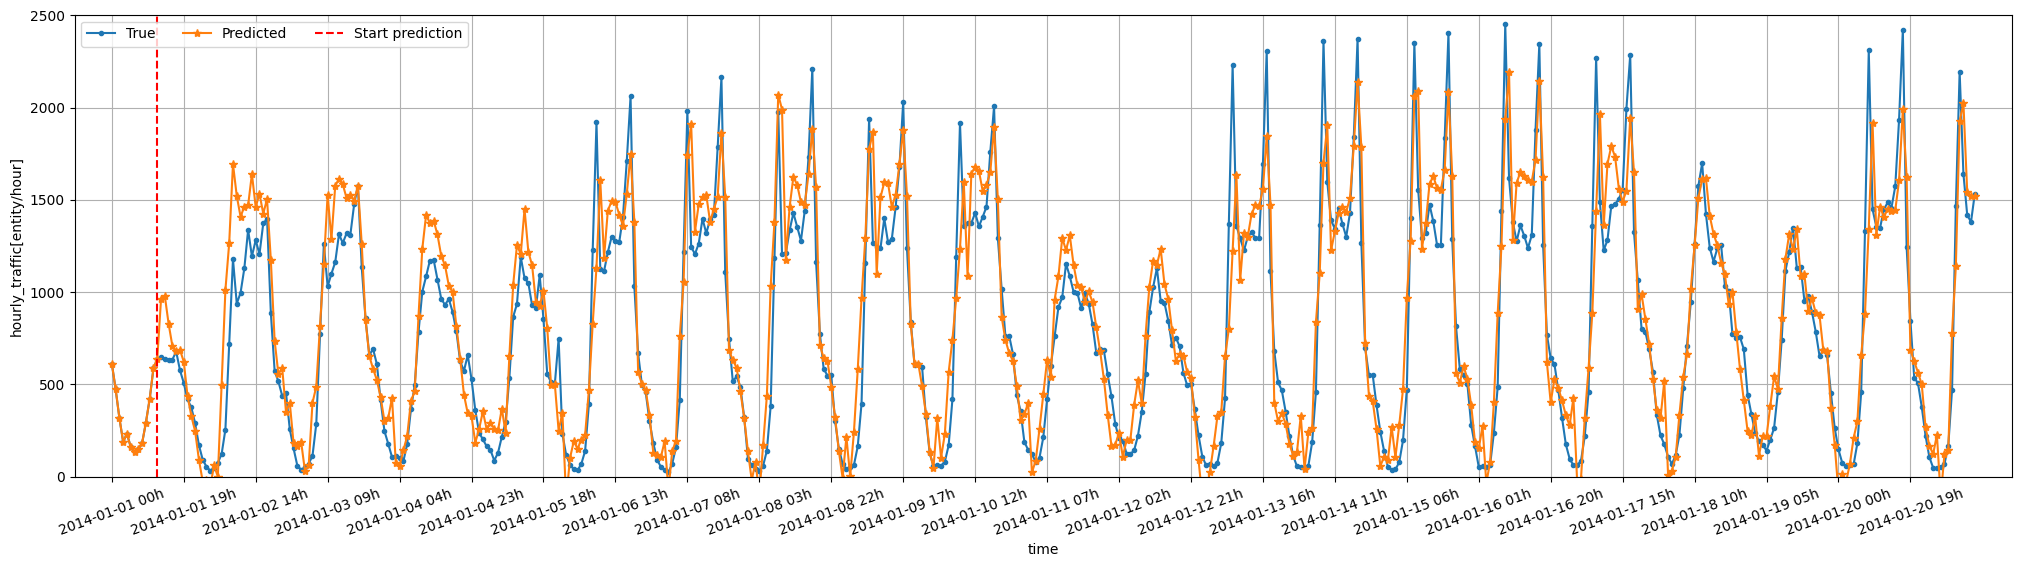

adding result to the log...


In [74]:
_ = trainer.fit_on(
    on_model=model,
    N_epochs=epochs,
    patience_RLR=patience_RLR,
    patience_ES=patience_ES,
    log=my_log,
    plot_range=plot_range,
    save_model=sv_model,
    save_step=sv_step,
)

### Two dense layers: non-Linear

Model: "old_dense_2-layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316,929 (1.21 MB)

 Trainable params: 316,929 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

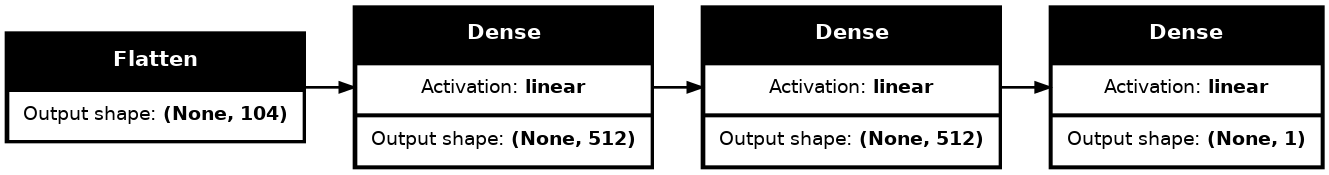

In [7]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(trainer.shape_X)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        tf.keras.layers.Dense(512),
        tf.keras.layers.Dense(trainer.shape_y),
    ]
)
model.name = "dense_2-layer"
plot_model_info(model)



Training:



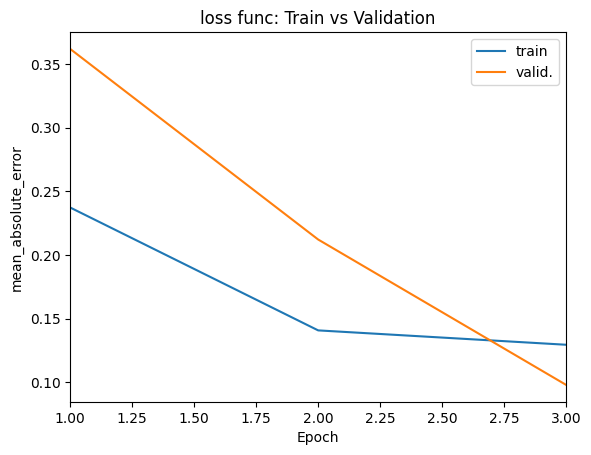

821/821 - 57s - 69ms/step - loss: 0.0347 - mean_absolute_error: 0.1296 - val_loss: 0.0240 - val_mean_absolute_error: 0.0981 - learning_rate: 0.0010
Epoch 4/12


KeyboardInterrupt: 

In [8]:
_ = trainer.fit_on(
    on_model=model,
    N_epochs=epochs,
    patience_RLR=patience_RLR,
    patience_ES=patience_ES,
    log=my_log,
    plot_range=plot_range,
    save_model=sv_model,
    save_step=sv_step,
)

## Convolutional Neural Network

Model: "Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 9, 4, 64)       │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_55 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

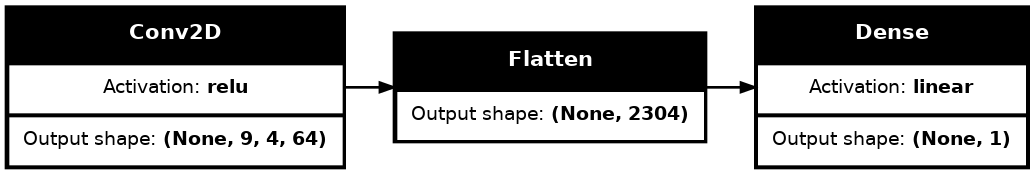

In [107]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(trainer.shape_X)),
        tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(trainer.shape_X[0])),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(trainer.shape_y)
    ]
)
model.name = "Conv1D"
plot_model_info(model)



Training:



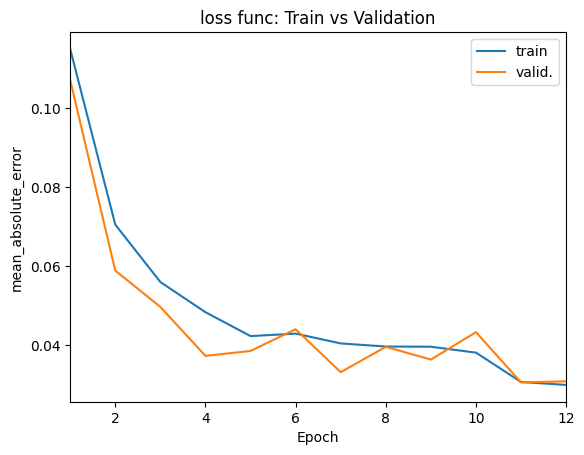

821/821 - 192s - 233ms/step - loss: 0.0022 - mean_absolute_error: 0.0300 - val_loss: 0.0025 - val_mean_absolute_error: 0.0309 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 11.

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 134s 162ms/step
mean_squared_error: 0.0022(0.0469) - mean_absolute_error: 0.0297
DeNorm_mean_squared_error: 6980.4512(83.5491) - DeNorm_mean_absolute_error: 53.5273


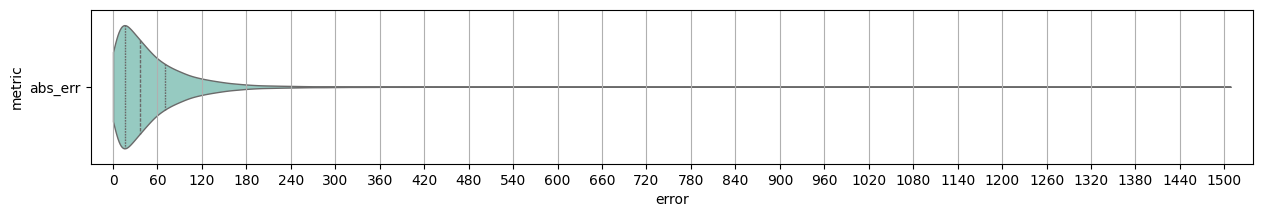

mean        std       min        25%       50%        75%  \
error  53.527321  64.151649  0.000618  16.050384  36.30083  70.080387   

               max  
error  1508.651066


Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step
mean_squared_error: 0.0025(0.0500) - mean_absolute_error: 0.0306
DeNorm_mean_squared_error: 8060.8169(89.7821) - DeNorm_mean_absolute_error: 55.1654


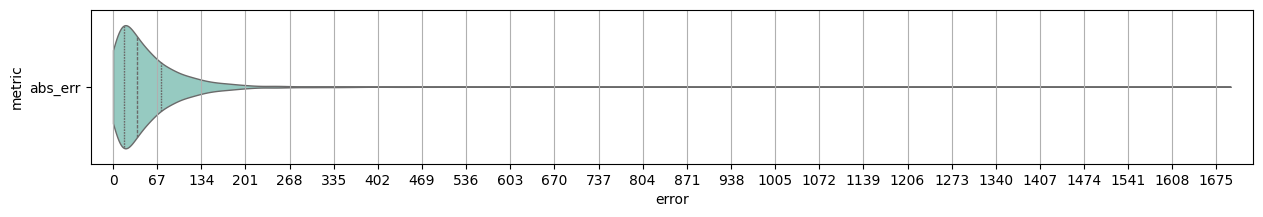

mean        std       min        25%        50%        75%  \
error  55.16542  70.839032  0.001192  16.458164  36.808325  72.115577   

               max  
error  1696.739888


Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step
mean_squared_error: 0.0027(0.0520) - mean_absolute_error: 0.0355
DeNorm_mean_squared_error: 8837.5977(94.0085) - DeNorm_mean_absolute_error: 63.9286


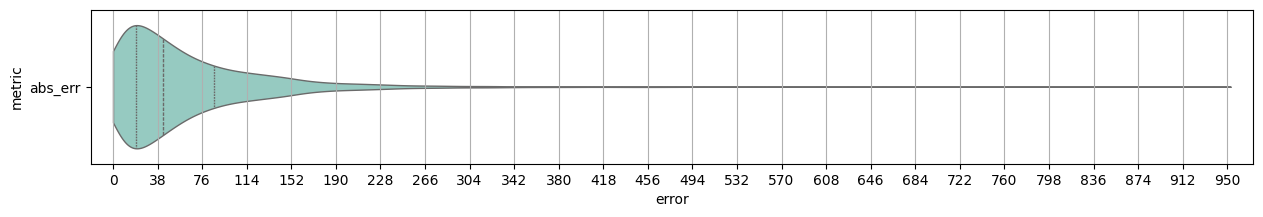

mean        std       min        25%        50%       75%  \
error  63.928621  68.929497  0.005861  19.405968  42.933708  86.06799   

              max  
error  953.041359

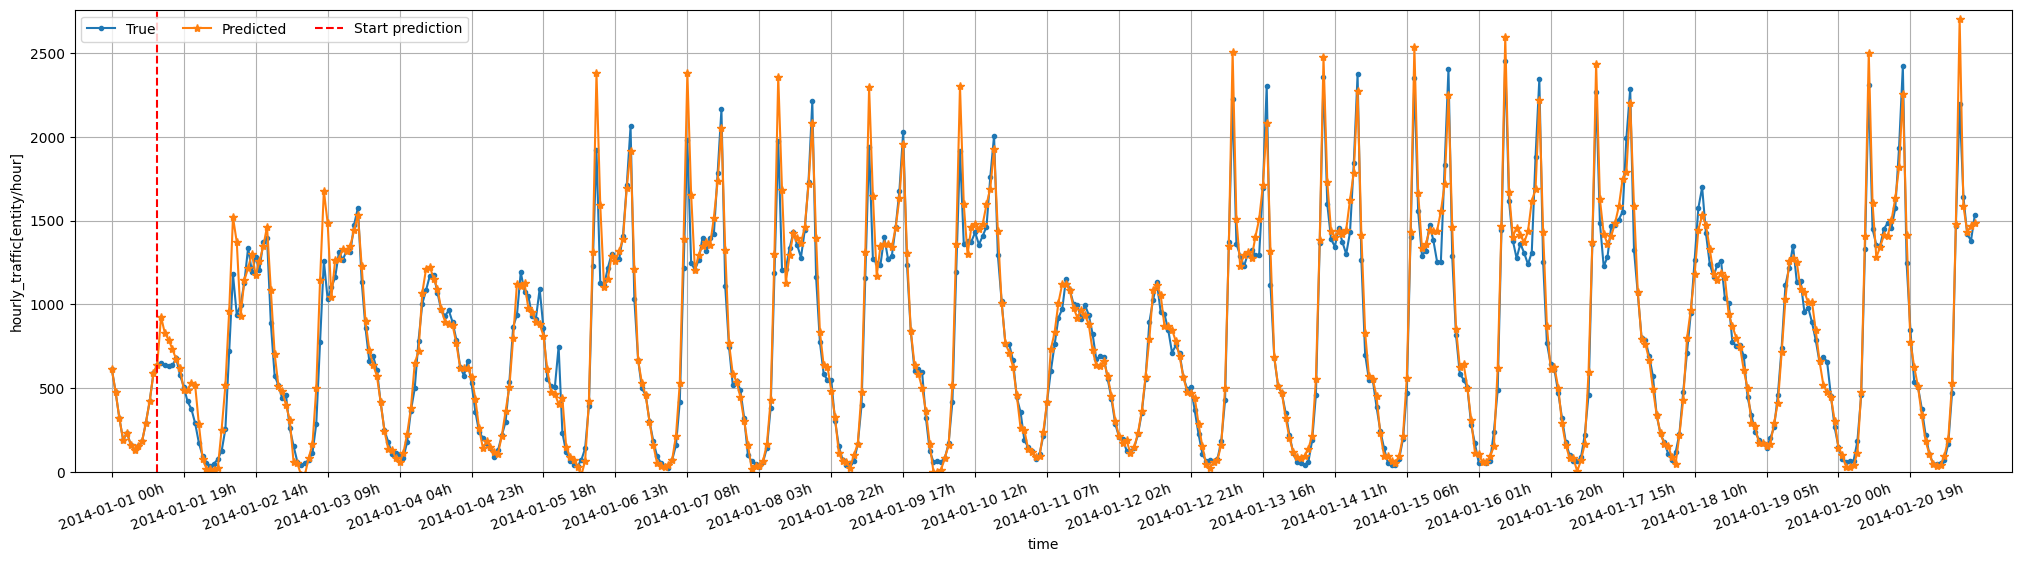

adding result to the log...


In [108]:
_ = trainer.fit_on(
    on_model=model,
    N_epochs=epochs,
    patience_RLR=patience_RLR,
    patience_ES=patience_ES,
    log=my_log,
    plot_range=plot_range,
    save_model=sv_model,
    save_step=sv_step,
)

## Recurrent Neurla Network

### Long-Short Term Memory

Model: "Simple_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       271,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,617 (1.04 MB)

 Trainable params: 271,617 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

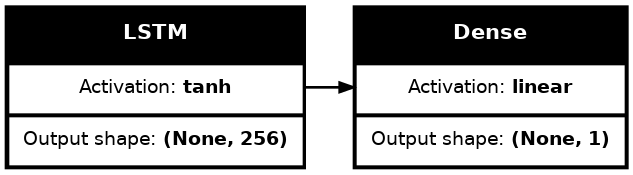

In [79]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(trainer.shape_X)),
        tf.keras.layers.LSTM(units=256),
        tf.keras.layers.Dense(trainer.shape_y),
    ]
)
model.name = "Simple_LSTM"
plot_model_info(model)



Training:



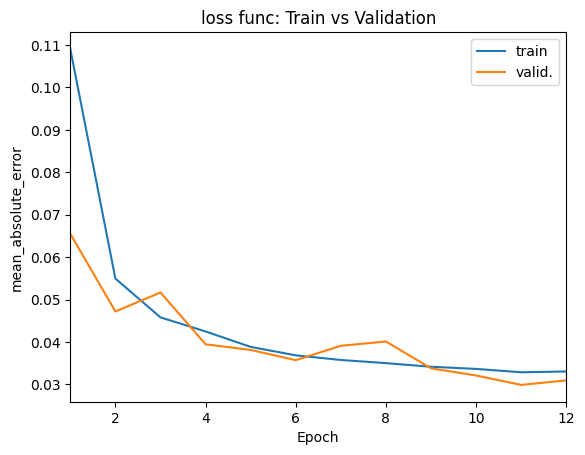

821/821 - 123s - 149ms/step - loss: 0.0024 - mean_absolute_error: 0.0330 - val_loss: 0.0023 - val_mean_absolute_error: 0.0309 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 11.

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 99s 121ms/step
mean_squared_error: 0.0020(0.0447) - mean_absolute_error: 0.0294
DeNorm_mean_squared_error: 6530.4146(80.8110) - DeNorm_mean_absolute_error: 52.9250


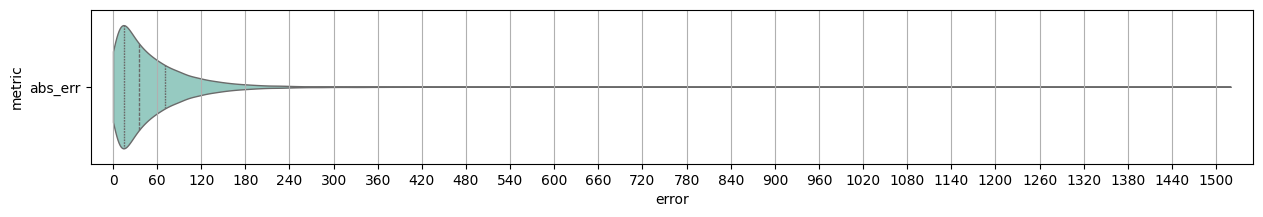

mean        std      min        25%        50%        75%  \
error  52.924954  61.069684  0.00399  15.308714  35.620816  71.287549   

               max  
error  1520.013547


Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step
mean_squared_error: 0.0023(0.0480) - mean_absolute_error: 0.0299
DeNorm_mean_squared_error: 7300.6416(85.4438) - DeNorm_mean_absolute_error: 53.7700


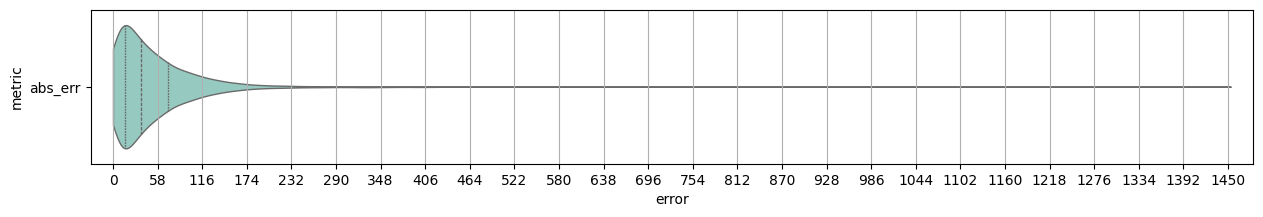

mean       std       min        25%        50%        75%  \
error  53.76999  66.40735  0.009192  15.351073  36.145637  71.037787   

               max  
error  1453.730646


Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step
mean_squared_error: 0.0028(0.0529) - mean_absolute_error: 0.0357
DeNorm_mean_squared_error: 9227.1328(96.0580) - DeNorm_mean_absolute_error: 64.1757


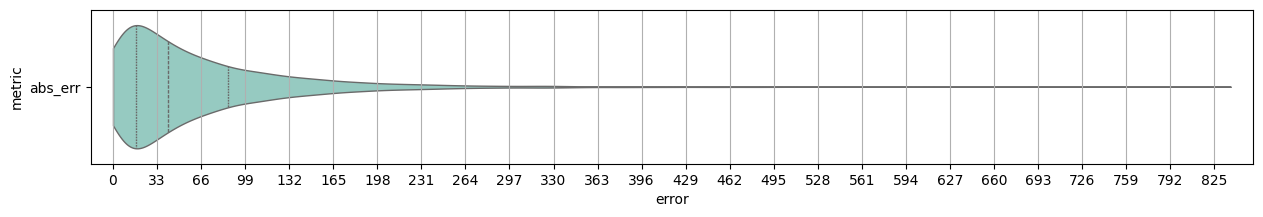

mean        std       min        25%        50%        75%  \
error  64.175734  71.478632  0.017497  17.553117  41.311544  86.092984   

              max  
error  837.312634

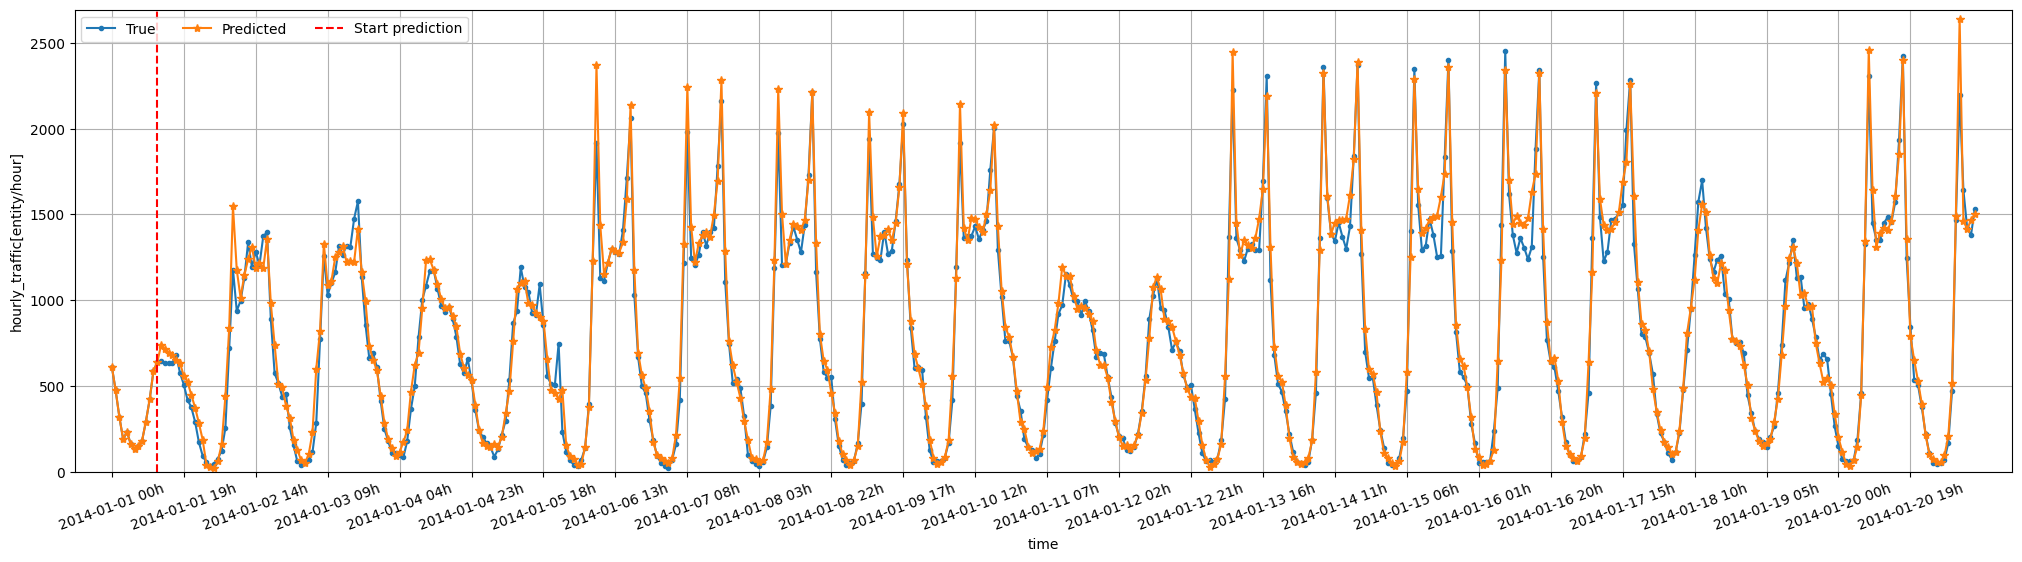

adding result to the log...


In [80]:
_ = trainer.fit_on(
    on_model=model,
    N_epochs=epochs,
    patience_RLR=patience_RLR,
    patience_ES=patience_ES,
    log=my_log,
    plot_range=plot_range,
    save_model=sv_model,
    save_step=sv_step,
)

Model: "Stacked_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 13, 256)        │       271,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,185 (3.10 MB)

 Trainable params: 813,185 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

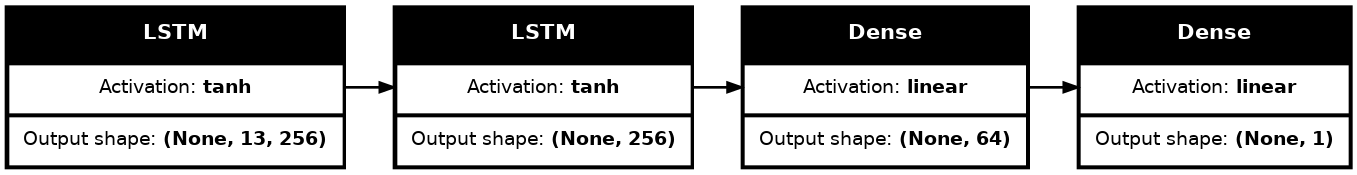

In [95]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(trainer.shape_X)),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.LSTM(units=256, return_sequences=False),
    tf.keras.layers.Dense(units=64, activation="linear"),
    tf.keras.layers.Dense(units=trainer.shape_y, activation="linear")
])
model.name = "Stacked_LSTM"
plot_model_info(model)



Training:



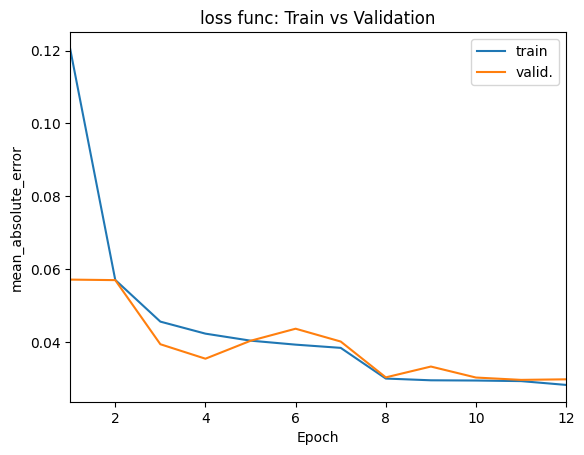

821/821 - 117s - 143ms/step - loss: 0.0019 - mean_absolute_error: 0.0283 - val_loss: 0.0022 - val_mean_absolute_error: 0.0298 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 11.

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 88s 106ms/step
mean_squared_error: 0.0019(0.0436) - mean_absolute_error: 0.0288
DeNorm_mean_squared_error: 6264.7959(79.1505) - DeNorm_mean_absolute_error: 51.8035


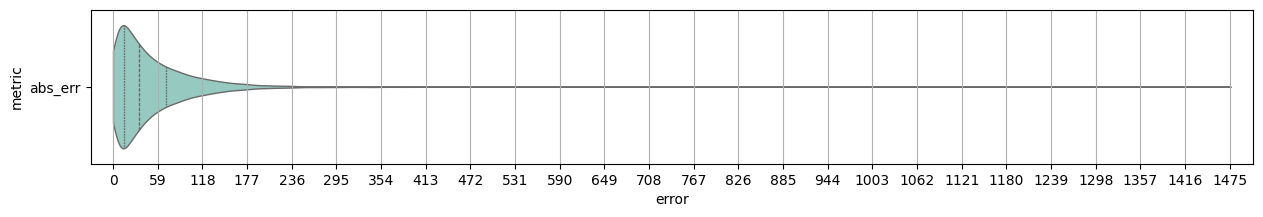

mean        std      min        25%        50%        75%  \
error  51.803541  59.844175  0.00234  14.538673  34.251009  70.436398   

               max  
error  1476.331735


Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step
mean_squared_error: 0.0022(0.0469) - mean_absolute_error: 0.0296
DeNorm_mean_squared_error: 7185.6328(84.7681) - DeNorm_mean_absolute_error: 53.3563


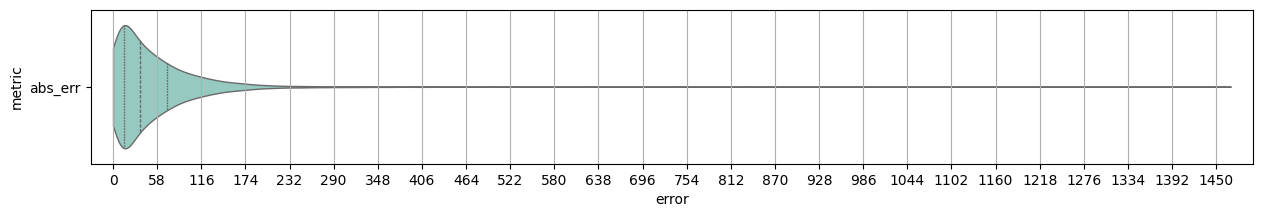

mean        std       min        25%        50%        75%  \
error  53.356345  65.872845  0.001258  14.772073  35.250114  71.596758   

               max  
error  1469.272867


Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step
mean_squared_error: 0.0026(0.0510) - mean_absolute_error: 0.0342
DeNorm_mean_squared_error: 8453.0684(91.9406) - DeNorm_mean_absolute_error: 61.6456


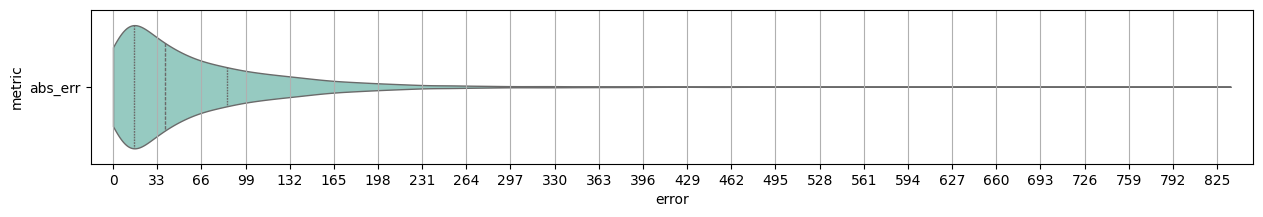

mean        std       min        25%        50%        75%  \
error  61.645566  68.216024  0.000182  15.730552  39.170485  84.985677   

              max  
error  835.222656

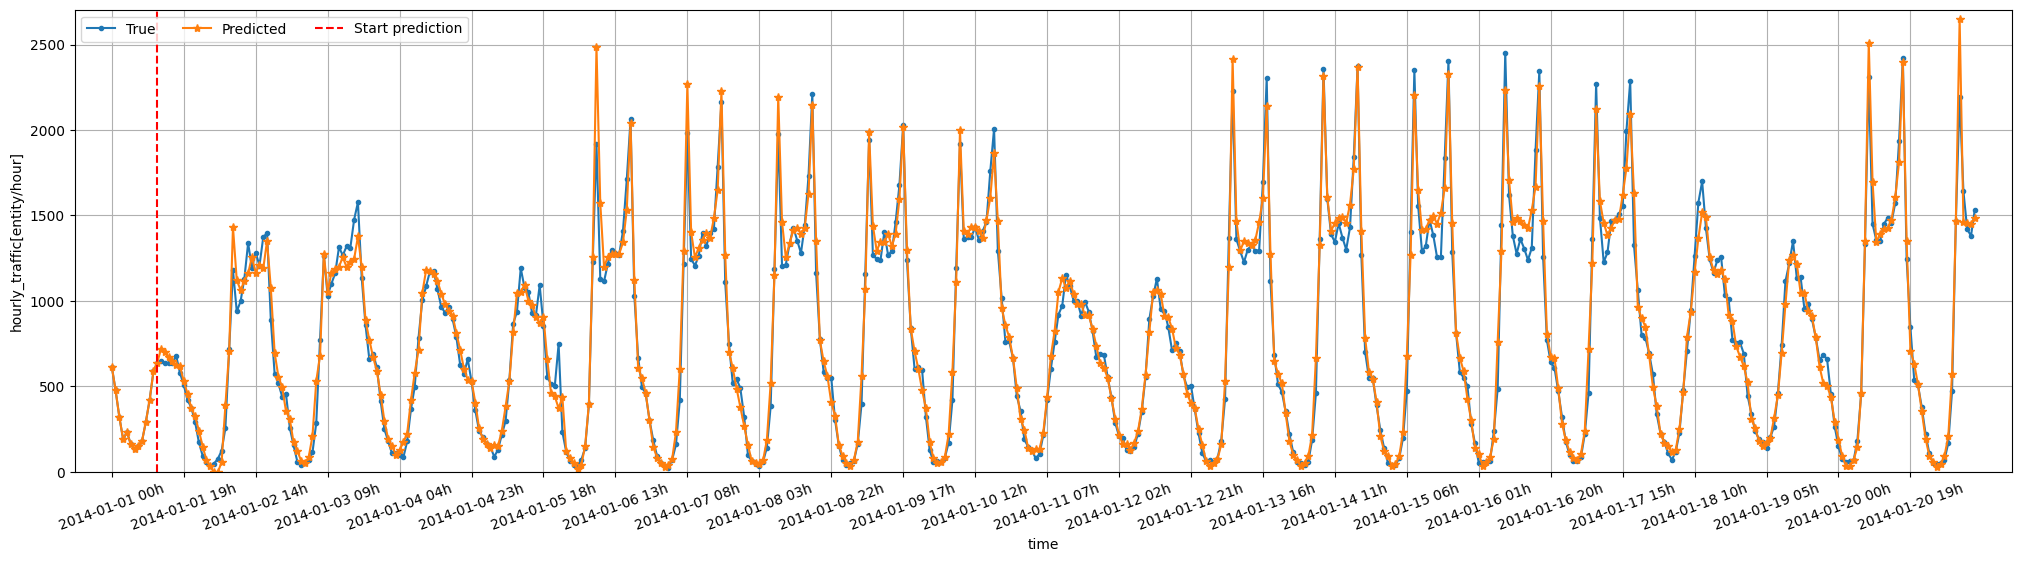

In [82]:
_ = trainer.fit_on(
    on_model = model,
    N_epochs = epochs,
    patience_RLR = patience_RLR,
    patience_ES = patience_ES,
    plot_range=plot_range,
    save_model=sv_model,
    save_step=sv_step,
)

### Gated Recurrent Network

Model: "old_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 256)            │       204,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,545 (799.00 KB)

 Trainable params: 204,545 (799.00 KB)

 Non-trainable params: 0 (0.00 B)

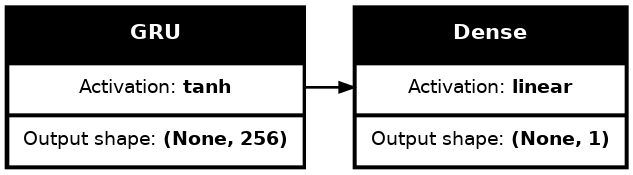

In [83]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(trainer.shape_X)),
        tf.keras.layers.GRU(units=256),
        tf.keras.layers.Dense(trainer.shape_y),
    ]
)
model.name="GRU"
plot_model_info(model)



Training:



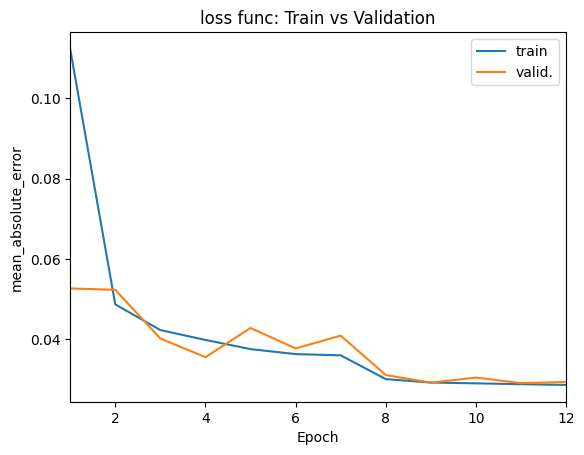


Epoch 12: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
821/821 - 126s - 153ms/step - loss: 0.0019 - mean_absolute_error: 0.0286 - val_loss: 0.0021 - val_mean_absolute_error: 0.0293 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 11.

Training Score:
821/821 ━━━━━━━━━━━━━━━━━━━━ 102s 124ms/step
mean_squared_error: 0.0019(0.0436) - mean_absolute_error: 0.0283
DeNorm_mean_squared_error: 6087.9834(78.0255) - DeNorm_mean_absolute_error: 50.9238


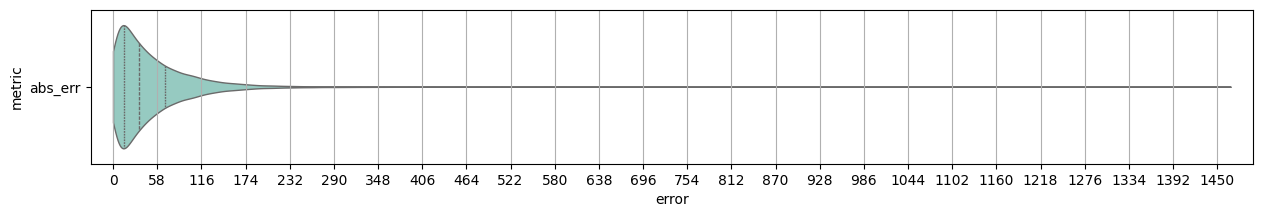

mean        std       min        25%        50%        75%  \
error  50.923846  59.117499  0.001481  14.791356  34.381252  68.571401   

               max  
error  1467.824626


Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step
mean_squared_error: 0.0021(0.0458) - mean_absolute_error: 0.0291
DeNorm_mean_squared_error: 6690.0718(81.7929) - DeNorm_mean_absolute_error: 52.2991


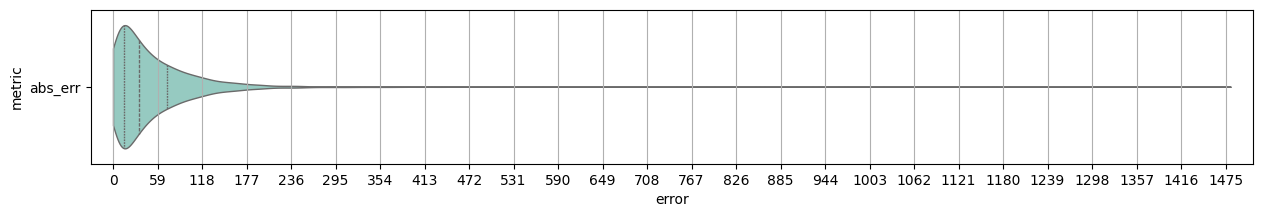

mean        std       min        25%        50%        75%  \
error  52.299061  62.891451  0.005083  14.532606  34.407664  71.395939   

               max  
error  1481.965509


Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step
mean_squared_error: 0.0027(0.0520) - mean_absolute_error: 0.0358
DeNorm_mean_squared_error: 8804.4922(93.8323) - DeNorm_mean_absolute_error: 64.4093


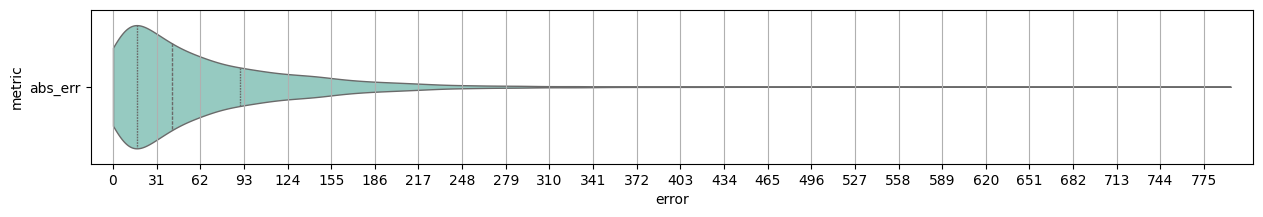

mean        std       min        25%        50%        75%  \
error  64.409261  68.238361  0.007373  17.040907  41.803053  90.413625   

              max  
error  794.038051

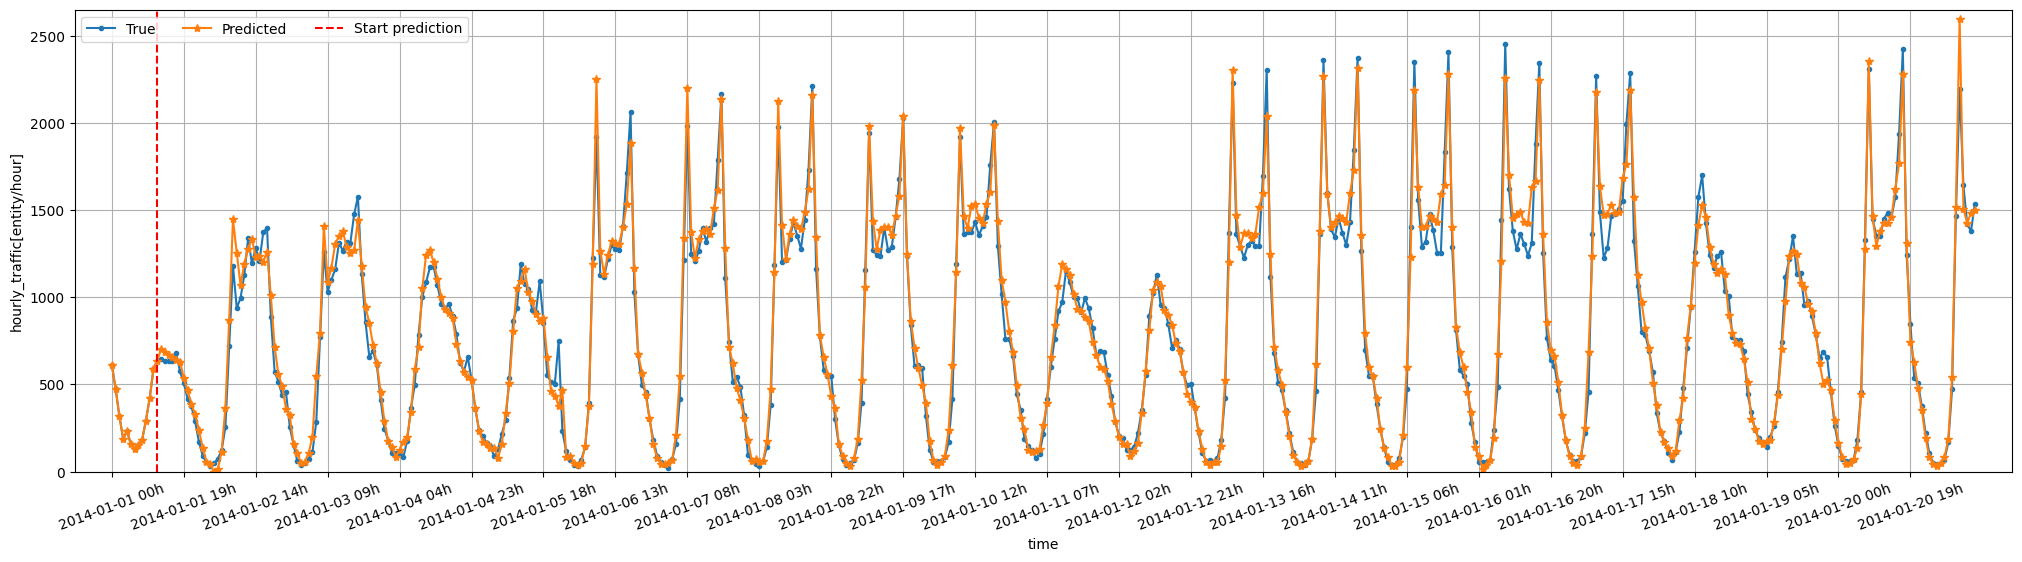

adding result to the log...


In [84]:
_ = trainer.fit_on(
    on_model=model,
    N_epochs=epochs,
    patience_RLR=patience_RLR,
    patience_ES=patience_ES,
    log=my_log,
    plot_range=plot_range,
    save_model=sv_model,
    save_step=sv_step,
)

# Comparison between models

In [85]:
my_log.save_into_workspace()
my_log.to_dataframe()

mean_squared_error  mean_absolute_error  val_mean_squared_error  \
Linear                   0.0220               0.0989                  0.0219   
Conv1D                   0.0018               0.0275                  0.0022   
Simple_LSTM              0.0020               0.0294                  0.0023   
old_GRU                  0.0019               0.0283                  0.0021   

             val_mean_absolute_error  test_mean_squared_error  \
Linear                        0.0998                   0.0215   
Conv1D                        0.0295                   0.0028   
Simple_LSTM                   0.0299                   0.0028   
old_GRU                       0.0291                   0.0027   

             test_mean_absolute_error  
Linear                         0.1021  
Conv1D                         0.0360  
Simple_LSTM                    0.0357  
old_GRU                        0.0358

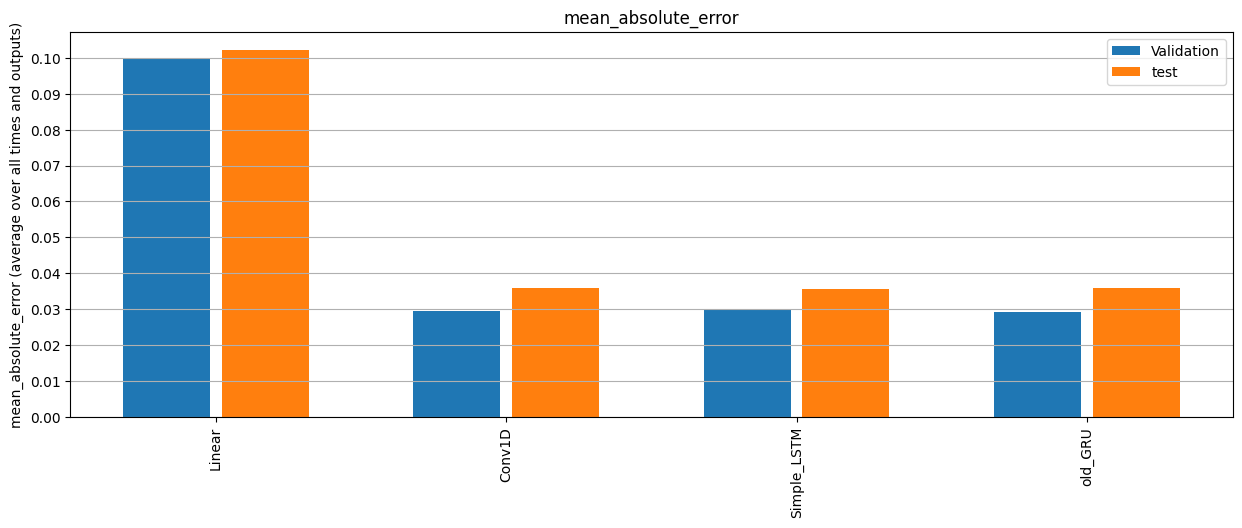

In [86]:
my_log.plot_bar_metric("mean_absolute_error")

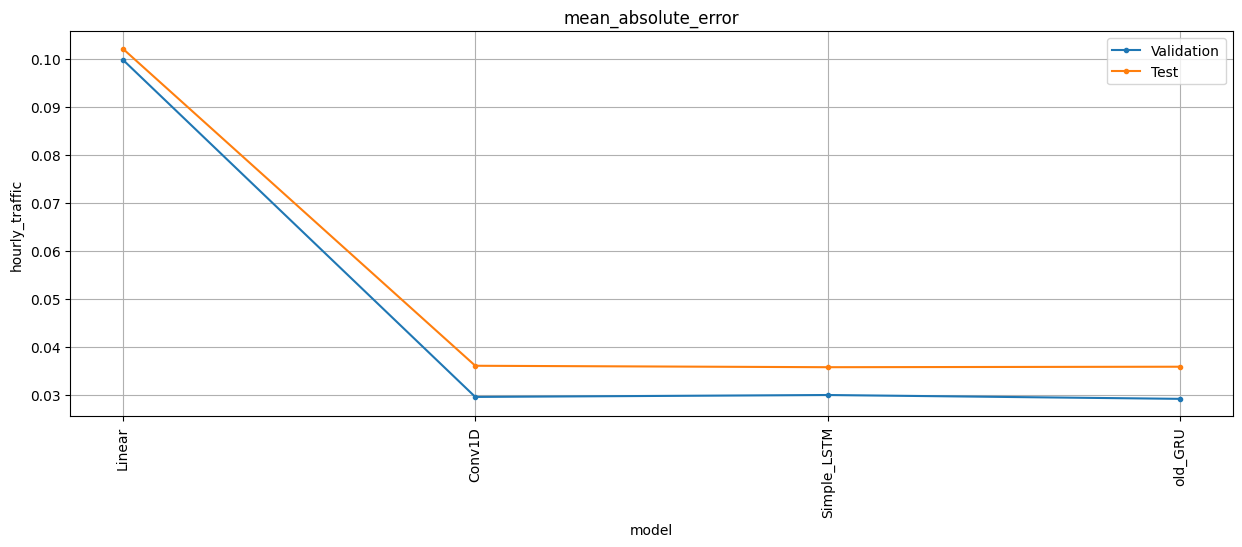

In [87]:
my_log.plot_metric("mean_absolute_error")

## Prediction on a random site

Sorting del site

Sito: 80, Info generali:


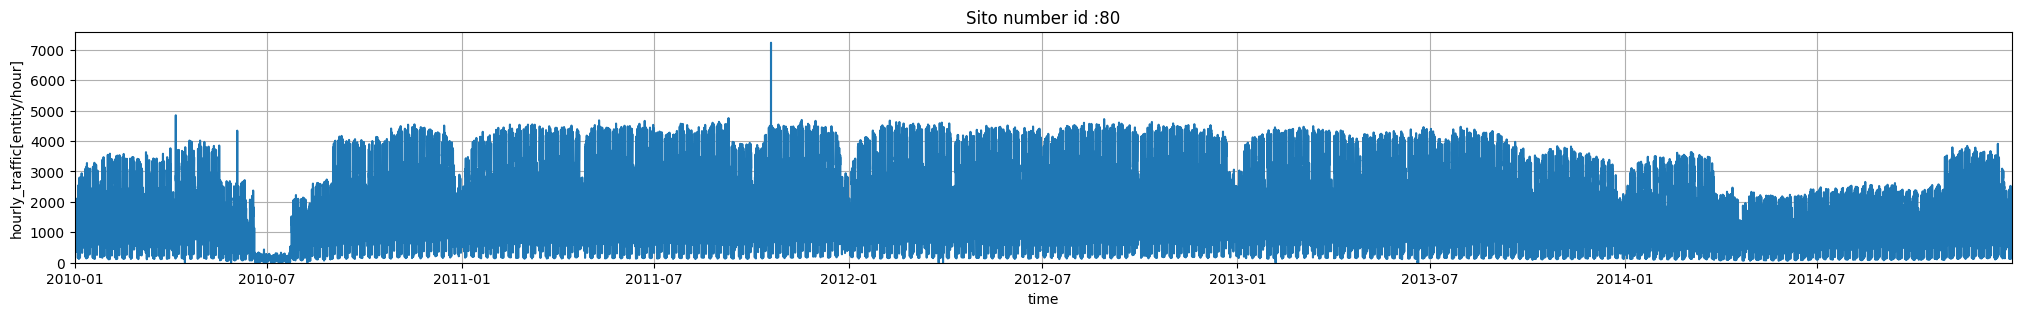

mean       std       min       25%       50%  \
hourly_traffic        1.033176  0.659833  0.000000  0.441111  0.982222   
temperature_2m        0.833086  0.301616  0.117000  0.612000  0.774500   
apparent_temperature  0.721823  0.344139 -0.049737  0.465404  0.656857   
relative_humidity_2m  0.657317  0.197985  0.081371  0.516910  0.679468   
precipitation         0.010049  0.049863  0.000000  0.000000  0.000000   
wind_speed_10m        1.068027  0.514500  0.000000  0.686417  1.012845   
cloud_cover           0.338667  0.311726  0.000000  0.030000  0.288000   

                           75%       max  
hourly_traffic        1.587222  4.015000  
temperature_2m        1.004500  2.019500  
apparent_temperature  0.925835  2.071331  
relative_humidity_2m  0.820077  1.000000  
precipitation         0.000000  1.560000  
wind_speed_10m        1.399428  3.755674  
cloud_cover           0.558000  1.000000

Site type: SD_SIGNALISED_T_JUNCTION
Sito: 80, Test set


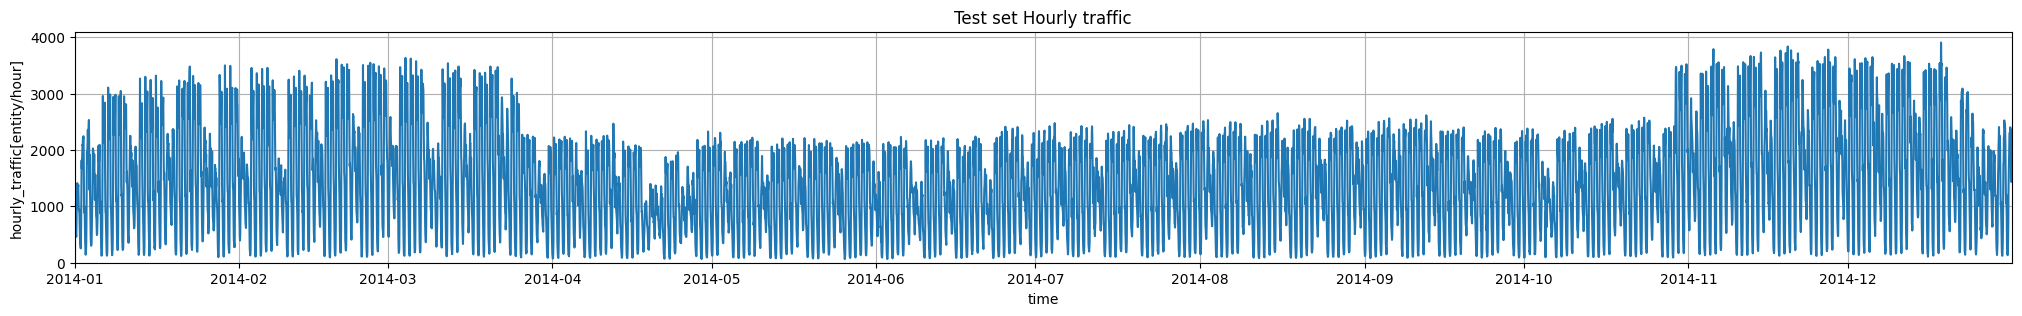

In [88]:
Exception_List = [-1, site_no, 15, 52, 57, 79, 82, 89, 100, 102, 110, 111]
metric_name = "mean_absolute_error"

Other_Site_No = -1
while Other_Site_No in Exception_List:
    Other_Site_No = random.randint(1, data.max_site_no)

print(f"Sito: {Other_Site_No}, Info generali:")
_ = data.select_site(Other_Site_No)

train, valid, test = data.split_and_get_generators(input_size=window_x, X_col=X_col)
print(f"Sito: {Other_Site_No}, Test set")
GeneralPlotter.plot_traffic(test.df, "Test set Hourly traffic")


del Exception_List, metric_name

Predizione


Linear:
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step
mean_squared_error: 0.0316(0.1778) - mean_absolute_error: 0.1253
DeNorm_mean_squared_error: 102296.6797(319.8385) - DeNorm_mean_absolute_error: 225.4897


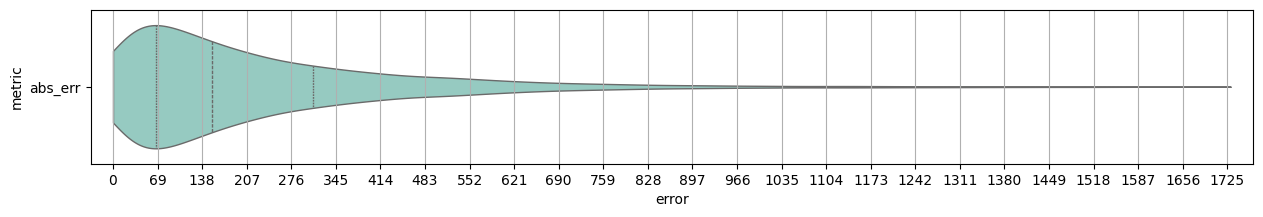

mean       std      min        25%         50%         75%  \
error  225.489708  226.8413  0.03304  67.332161  153.529304  310.369205   

               max  
error  1730.396719

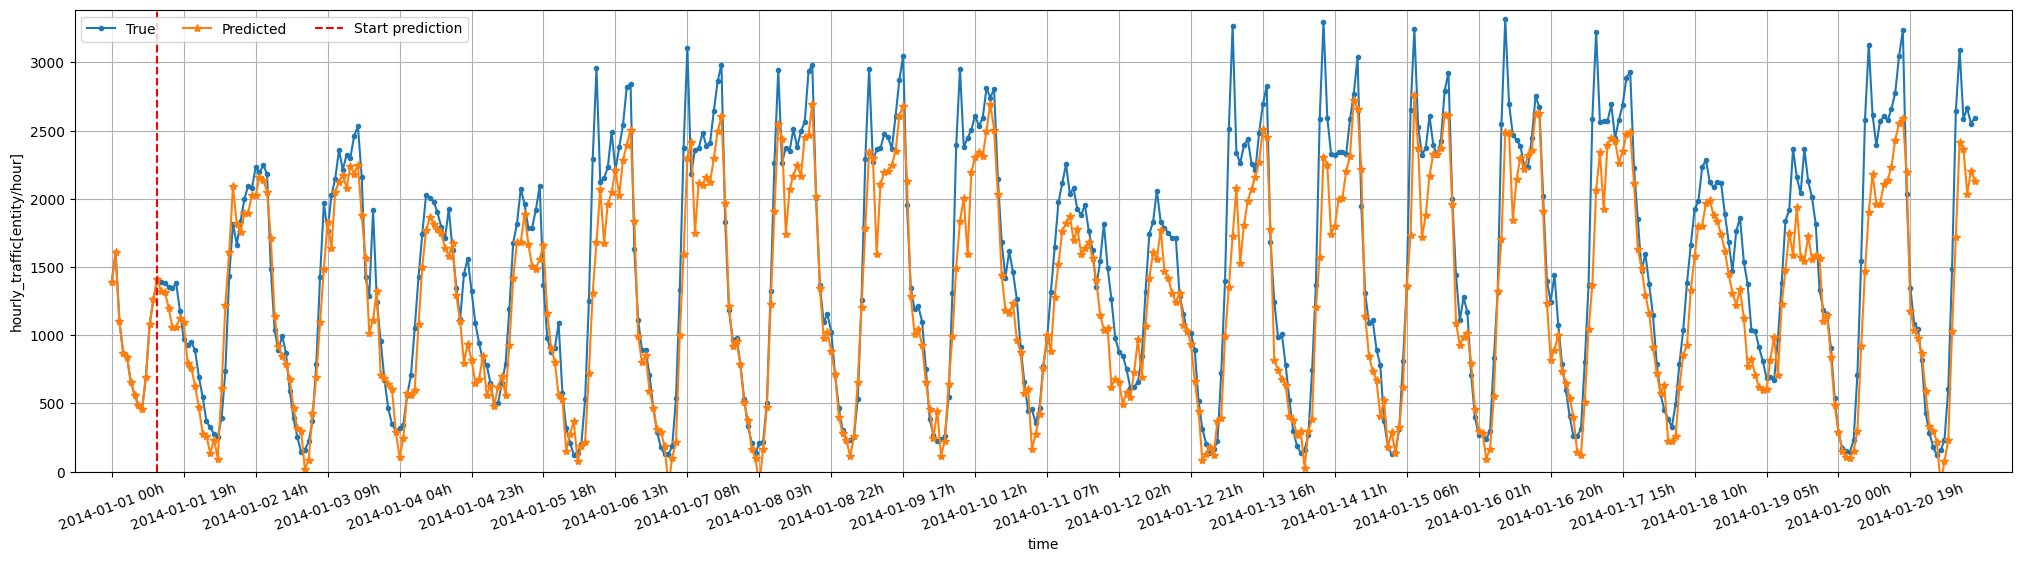

---


Conv1D:
272/272 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step
mean_squared_error: 0.0198(0.1407) - mean_absolute_error: 0.1004
DeNorm_mean_squared_error: 64104.1328(253.1879) - DeNorm_mean_absolute_error: 180.7614


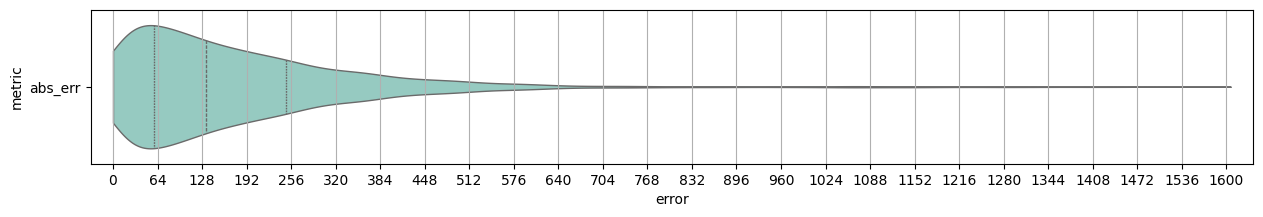

mean         std       min        25%         50%         75%  \
error  180.761345  177.293778  0.026044  58.811711  133.243409  248.290204   

               max  
error  1606.324382

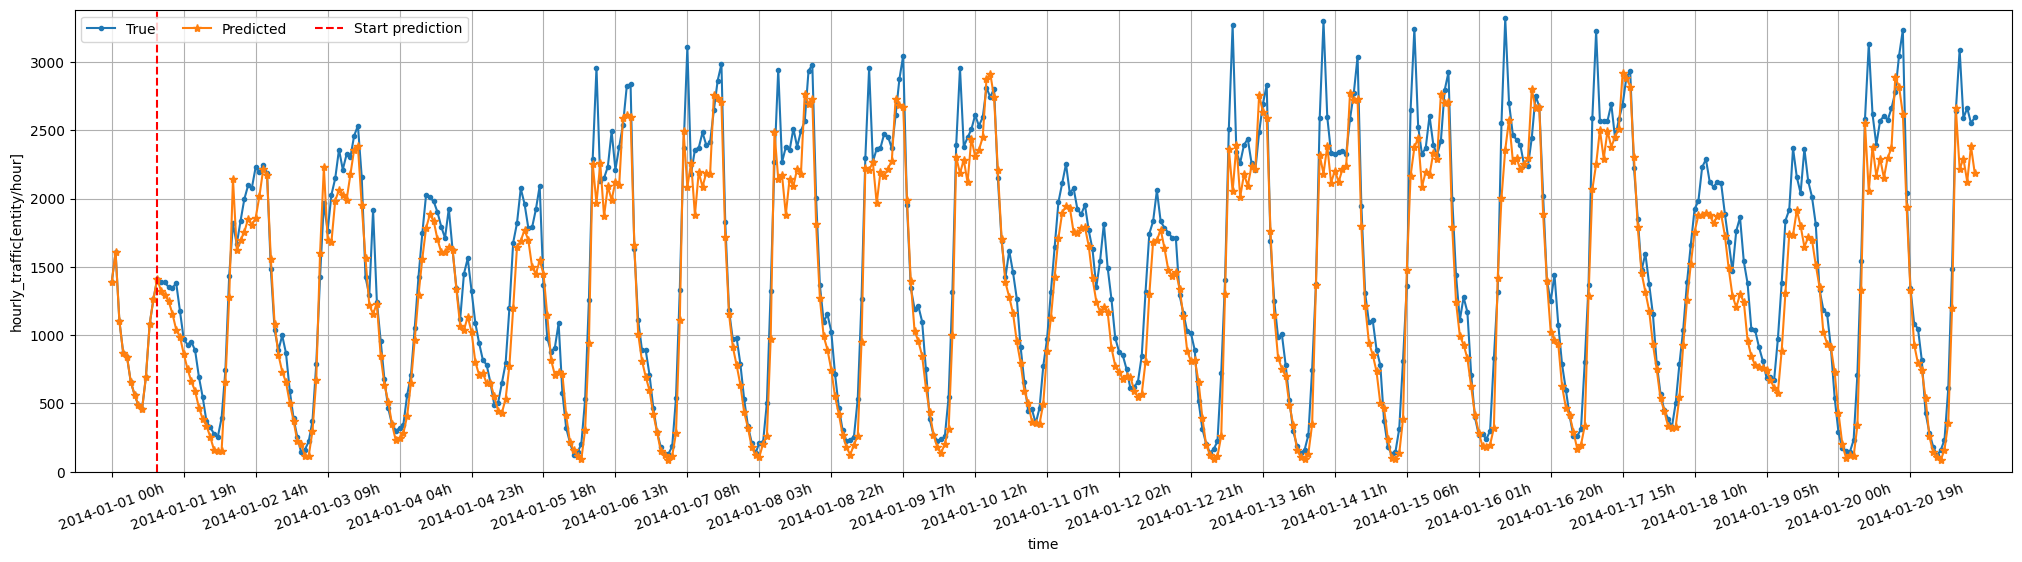

---


Simple_LSTM:
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step
mean_squared_error: 0.0240(0.1549) - mean_absolute_error: 0.1100
DeNorm_mean_squared_error: 77806.3828(278.9380) - DeNorm_mean_absolute_error: 197.9132


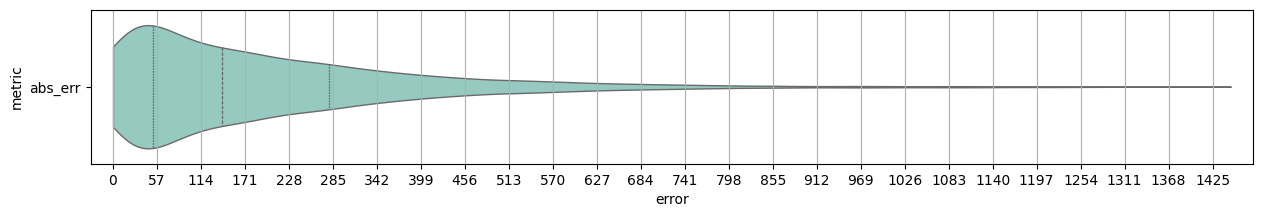

mean         std       min       25%         50%         75%  \
error  197.91316  196.573664  0.084522  52.37977  141.064466  279.936691   

               max  
error  1448.664346

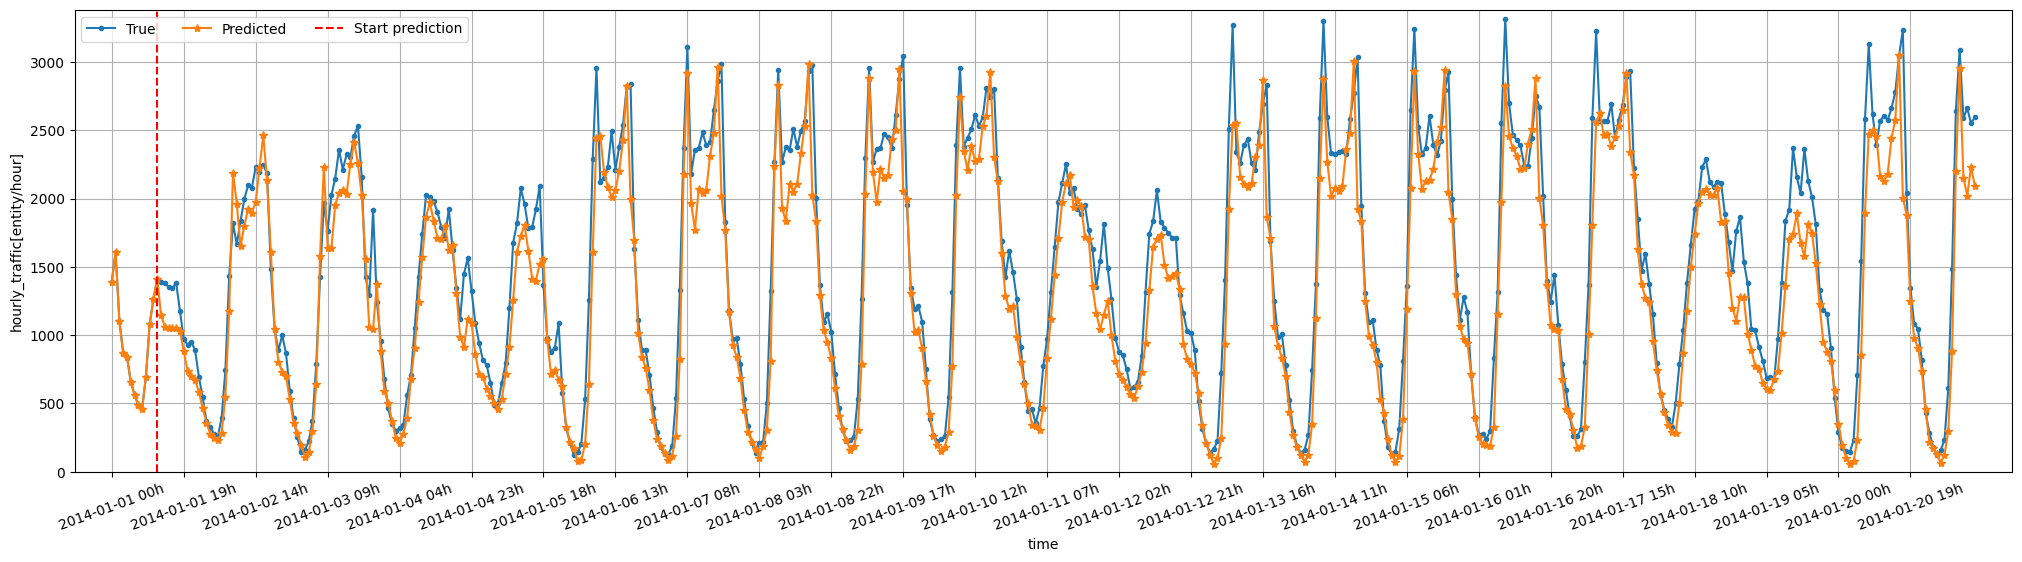

---


old_GRU:
272/272 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step
mean_squared_error: 0.0235(0.1533) - mean_absolute_error: 0.1115
DeNorm_mean_squared_error: 76089.8750(275.8439) - DeNorm_mean_absolute_error: 200.6606


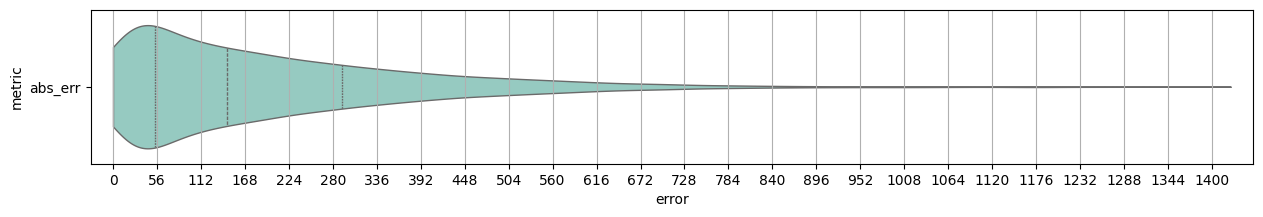

mean         std       min        25%         50%         75%  \
error  200.660591  189.286352  0.001074  54.069999  144.910614  291.276502   

               max  
error  1423.960776

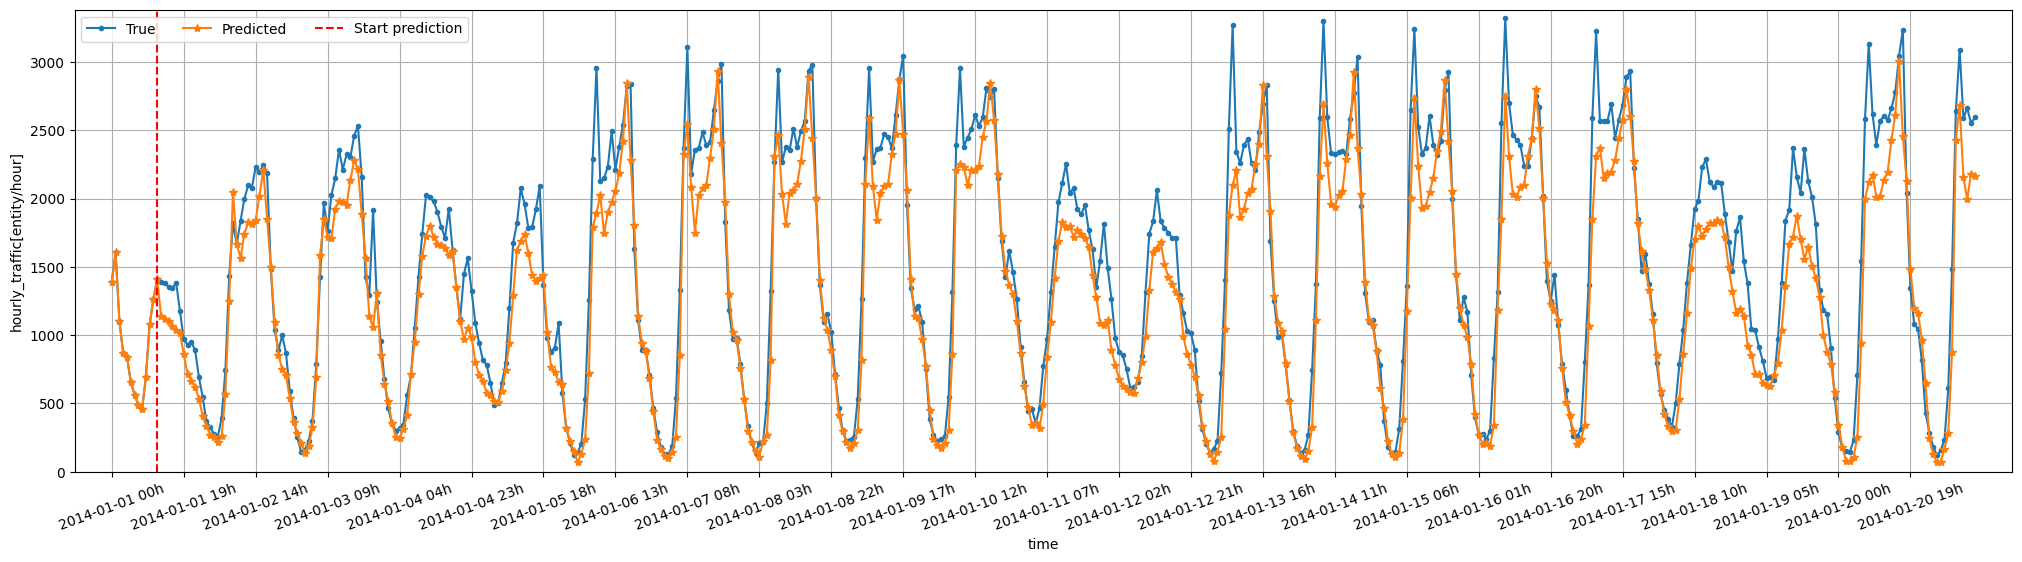

---

In [89]:
for key, value in my_log["my_models"].items():
    path = f"img/{workspace}/{value.name}/"
    os.makedirs(path, exist_ok=True)
    _ = Trainer.predict_and_compare(
        on_model=value,
        Generator=test,
        title=key,
        plot_range=plot_range,
        path = path + f"site_{Other_Site_No}_",
    )
    display(Markdown("---"))

## Import of pre-trained models

In [13]:
#my_models = {}
#extension = ".keras"
#for filename in os.listdir("./models"):
#    if filename.endswith(extension):
#        model_name = filename[: -len(extension)]  # Remove the extension
#        print(f"Importing {model_name}.keras...")
#        my_models[model_name] = tf.keras.models.load_model(
#            os.path.join("./models/", filename), safe_mode=False
#       )

Importing Best_model_on1Site.keras...
Importing Linear.keras...
Importing Multiple_site_from_single_Site_model_17.keras...
Importing Multiple_site_from_single_Site_model_19.keras...
Importing Multiple_site_from_single_Site_model_21.keras...
Importing Multiple_site_from_single_Site_model_56.keras...
Importing Multiple_site_StackedLSTM_SameTimestamp.keras...
Importing Multiple_site_StackedLSTM_ValidToTest.keras...
Importing old_Conv1D.keras...
Importing old_dense_2-layer.keras...
Importing old_GRU.keras...
Importing old_linear.keras...
Importing old_simple_LSTM.keras...
Importing tuned_LSTM_1.keras...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Importing tuned_LSTM_2.keras...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Importing tuned_LSTM_3.keras...


# Plot Real vs (all models)

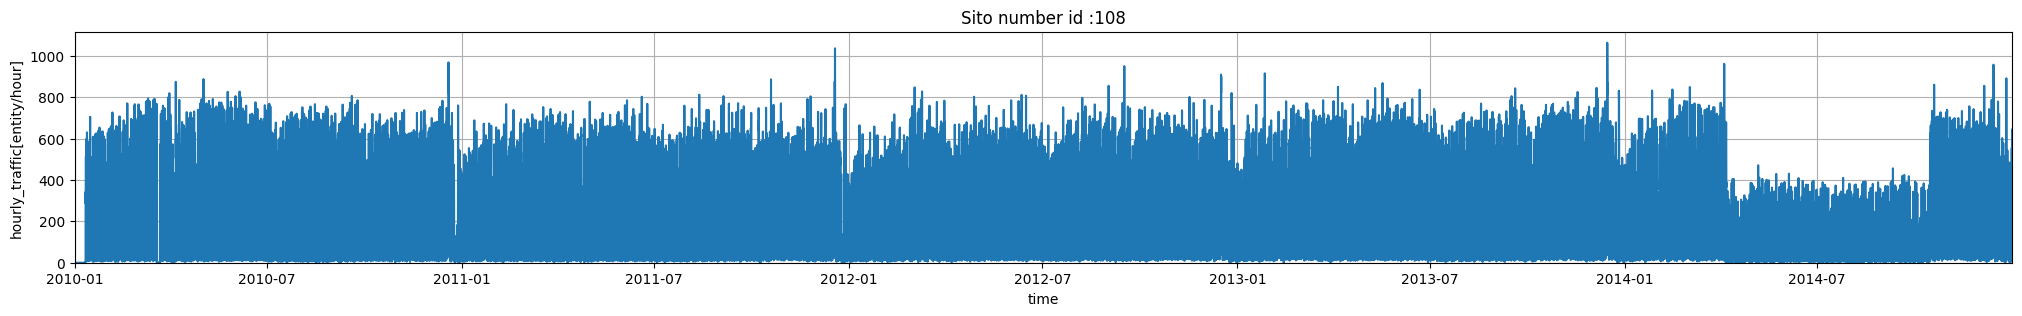

mean       std       min       25%       50%  \
hourly_traffic        0.132019  0.116493  0.000000  0.021111  0.091111   
temperature_2m        0.833086  0.301616  0.117000  0.612000  0.774500   
apparent_temperature  0.721823  0.344139 -0.049737  0.465404  0.656857   
relative_humidity_2m  0.657317  0.197985  0.081371  0.516910  0.679468   
precipitation         0.010049  0.049863  0.000000  0.000000  0.000000   
wind_speed_10m        1.068027  0.514500  0.000000  0.686417  1.012845   
cloud_cover           0.338667  0.311726  0.000000  0.030000  0.288000   

                           75%       max  
hourly_traffic        0.231667  0.590556  
temperature_2m        1.004500  2.019500  
apparent_temperature  0.925835  2.071331  
relative_humidity_2m  0.820077  1.000000  
precipitation         0.000000  1.560000  
wind_speed_10m        1.399428  3.755674  
cloud_cover           0.558000  1.000000

Site type: SD_SIGNALISED_PEDESTRIAN_CROSSING


In [91]:
site_no = 108
Site_data = data.select_site(site_no)


_, _, Test_108 = data.split_and_get_generators(
    training=3, validation=1, test=1, X_col=X_col, input_size=window_x
)
Test_10 = trainer.GenTest

In [9]:

my_models = my_log.my_models

In [45]:
prediction_10 = {
    "Linear": np.array(my_models["linear"].predict(Test_10)).flatten(),
    "two-layer Dense": np.array(my_models["dense_2-layer"].predict(Test_10)).flatten(),
    "CNN1D": np.array(my_models["Conv1D"].predict(Test_10)).flatten(),
    "one-layer LSTM": np.array(my_models["simple_LSTM"].predict(Test_10)).flatten(),
    "Stacked LSTM": np.array(my_models["Best_model_on1Site"].predict(Test_10)).flatten(),
    "GRU": np.array(my_models["GRU"].predict(Test_10)).flatten(),
}

prediction_108 = {
    "Linear": np.array(my_models["linear"].predict(Test_108)).flatten(),
    "two-layer Dense": np.array(my_models["dense_2-layer"].predict(Test_108)).flatten(),
    "CNN1D": np.array(my_models["Conv1D"].predict(Test_108)).flatten(),
    "one-layer LSTM": np.array(my_models["simple_LSTM"].predict(Test_108)).flatten(),
    "Stacked LSTM": np.array(my_models["Best_model_on1Site"].predict(Test_108)).flatten(),
    "GRU": np.array(my_models["GRU"].predict(Test_108)).flatten(),
}

272/272 ━━━━━━━━━━━━━━━━━━━━ 27s 98ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step


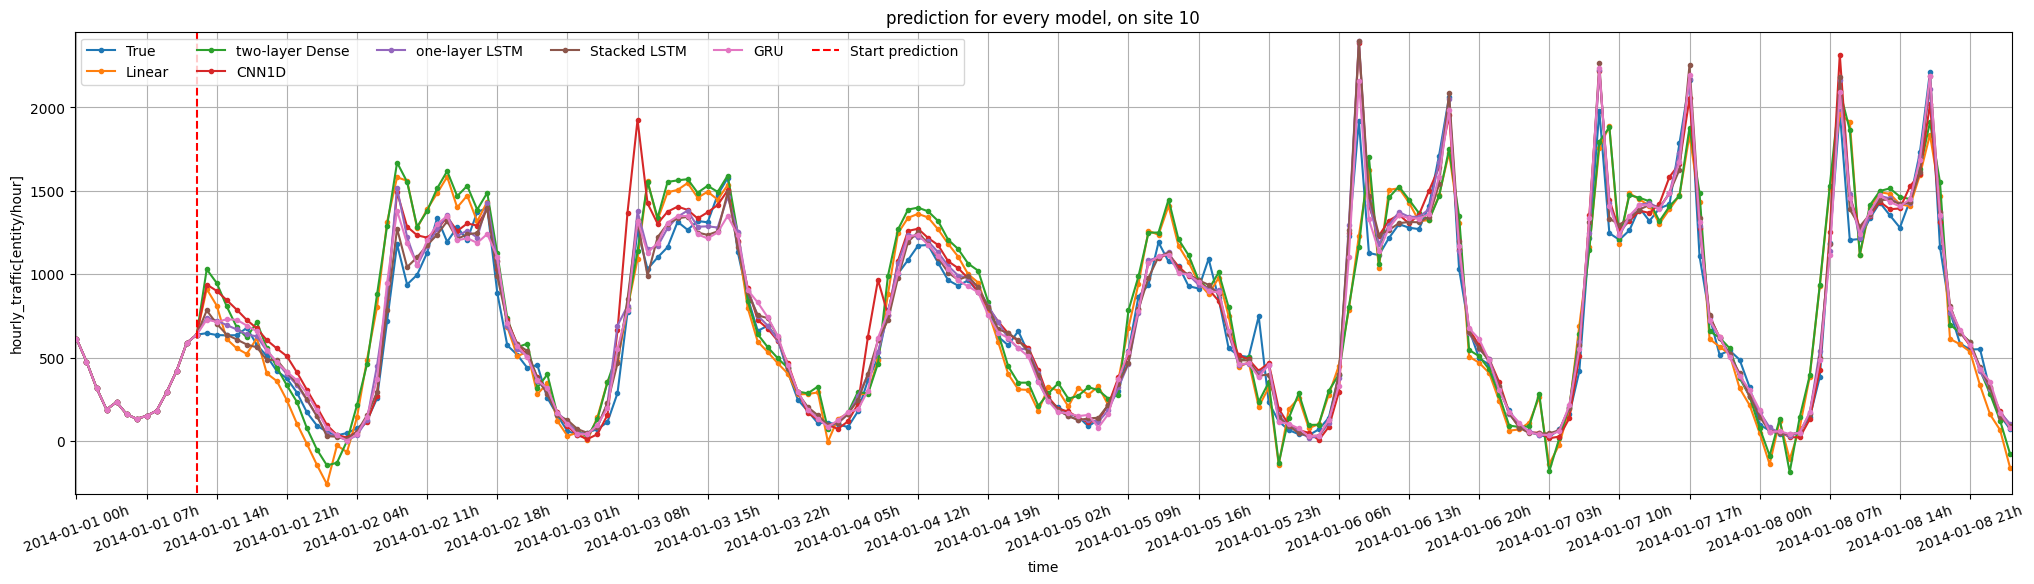

In [63]:
OnePlotter.multiple_model_compare_on_real(
    Test_10,
    prediction_10,
    title="prediction for every model, on site 10",
    plot_range=range(24*7+13),
    path=f"img/{workspace}/Site_{site_no}_multiple_models_compare"
)
OnePlotter.multiple_model_compare_on_real(
    Test_108,
    prediction_108,
    title="prediction for every model, on site 108",
    plot_range=range(24*7+13),
    path = f"img/{workspace}/Site_{Other_Site_No}_multiple_model_compare"
)